In [1]:
# inline plotting

%matplotlib inline

In [2]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Breast Cancer

## EDA and Dimensionality Reduction

### Problem to solve

There are more than 2.3 million cases of breast cancer that occur each year. This statistic makes it the most common cancer among adults. In 95% of countries breast cancer is the first or second leading cause of female cancer deaths. Breast Cancer occurs as a result of abnormal growth of cells in the breast tissue, commonly referred to as a Tumor. A tumor does not mean cancer - tumors can be **benign** (not cancerous), pre-malignant (pre-cancerous), or **malignant** (cancerous). Tests such as MRI, mammogram, ultrasound, and biopsy are commonly used to diagnose breast cancer performed.

However, this is a curable if detected in an early-stage as a non-metastatic disease. This underlies the importance of early detection and the need to conduct research in these lines.

### Data Sources

We get three datasets - one from Eurostat with annual data about breast cancer cases in EU countries. Second and third datasets are from UCI machine learning repository. Third dataset is well known for the many features related to the breast cancer cells parameters. 

The datasets differ in the data they preserve. They are valuable in different ways. Let's explore the datasets one by one to see how we are going to aproach our **goal to predict correct breast cancer diagnosis.**

### Eurostat Data

The table is public and available on the [Eurostat website](https://ec.europa.eu/eurostat/databrowser/view/HLTH_PS_SCRE$DEFAULTVIEW/default/table?lang=en). There are 963 rows with annually aggregated data in percentage. The columns are 10.

In [3]:
bc_eurostat = pd.read_csv("data\eurostat_breast_data.csv")

In [4]:
# Let's rename and make the column names more pythonic.

bc_eurostat.columns = bc_eurostat.columns.str.lower()
bc_eurostat["last_update"] = bc_eurostat["last update"]
bc_eurostat = bc_eurostat.drop(columns = ["last update"])

In [5]:
bc_eurostat.shape

(963, 10)

In [6]:
bc_eurostat.dtypes

dataflow        object
freq            object
unit            object
source          object
icd10           object
geo             object
time_period      int64
obs_value      float64
obs_flag        object
last_update     object
dtype: object

We see eight categorical fields and two numeric which is expected due to the data contained in the table.

In [7]:
#Let's check for missing values in the dataset

bc_eurostat.isnull().sum()

dataflow         0
freq             0
unit             0
source           0
icd10            0
geo              0
time_period      0
obs_value        0
obs_flag       649
last_update      0
dtype: int64

Some of the fields in the column *obs_flag* are missing - 649. Let's explore this field further. We need checking if this is an issue and how to address it.

In [8]:
bc_eurostat.obs_flag.unique()

array([nan, 'b', 'd', 'e', 'dp', 'p', 'bd'], dtype=object)

According to the documentation *obs_flag* string values correspond to:
- b: break in time series; 
- d: definition differs; 
- e: estimated; 
- bd: break in time series, definition differs; 
- dp: definition differs, provisional; 
- p: provisional.

This column gives an information on the way the data is presented. The missing values are not an issue, as we are not going to work with this column further. I will leave them as they are, without removing observations or replacing them.

In [9]:
# Let's have a look at the table.

bc_eurostat.head()

,dataflow,freq,unit,source,icd10,geo,time_period,obs_value,obs_flag,last_update
0,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,BE,2001,50.0,NaN,12/07/22 11:00:00
1,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,BE,2002,54.0,NaN,12/07/22 11:00:00
2,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,BE,2003,53.7,NaN,12/07/22 11:00:00
3,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,BE,2004,55.9,NaN,12/07/22 11:00:00
4,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,BE,2005,56.6,NaN,12/07/22 11:00:00


In [10]:
bc_eurostat.dataflow.unique(), bc_eurostat["last_update"].unique()

(array(['ESTAT:HLTH_PS_SCRE(1.0)'], dtype=object),
 array(['12/07/22 11:00:00'], dtype=object))

The first and the last columns of Eurostat dataset doesn't tell us anything but the name and last update of the dataset. We have one unique value per column. We will exclude them from the EDA, as we don't get meaningful information.

In [11]:
bc_eurostat.freq.unique(), bc_eurostat.unit.unique()

(array(['A'], dtype=object), array(['PC'], dtype=object))

According to the documentation second and third columns tell us the data is agregated annually. The measure unit is percentage.

In [12]:
print("Unique medical diagnosis: ", bc_eurostat.icd10.unique()) 

print("List of the countires included in the research: ", bc_eurostat.geo.unique())
print("Number of countries is: ", len(bc_eurostat.geo.unique()))

print("Years of observations: ", bc_eurostat.time_period.unique())

Unique medical diagnosis:  ['C50' 'C53']
List of the countires included in the research:  ['BE' 'BG' 'CY' 'CZ' 'DE' 'DK' 'EE' 'FI' 'FR' 'HR' 'HU' 'IE' 'IS' 'IT'
 'LI' 'LT' 'LU' 'LV' 'ME' 'MK' 'MT' 'NL' 'NO' 'RO' 'RS' 'SI' 'SK' 'TR'
 'UK' 'SE' 'AT' 'CH' 'EL' 'ES' 'PL' 'PT']
Number of countries is:  36
Years of observations:  [2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018 2019 2020 2021 2000]


The column "icd10" corresponds to medical codes for diagnosis:
- C50: Malignant neoplasm of breast, 
- C53: Malignant neoplasm of cervix uteri. 

The observations include 36 european countries. Period of observation is from 2000 to 2021 inclusive.
Interesting fields are "geo" - country name, "time_period" - year and "obs_value" - calculated percentage.

Let's create some visualization to get sense of the data.

**2021 Figures**

We can check how the figures for 2021 look like.

In [13]:
# Let's pull out the data for 2021

data_2021 = bc_eurostat[bc_eurostat.time_period == 2021]
data_2021.head(10)

,dataflow,freq,unit,source,icd10,geo,time_period,obs_value,obs_flag,last_update
141,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,HR,2021,56.0,NaN,12/07/22 11:00:00
238,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,LT,2021,45.5,p,12/07/22 11:00:00
272,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,LV,2021,30.8,NaN,12/07/22 11:00:00
289,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,MT,2021,77.8,NaN,12/07/22 11:00:00
332,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,NO,2021,65.5,NaN,12/07/22 11:00:00
343,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,RS,2021,5.2,NaN,12/07/22 11:00:00
355,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C50,SI,2021,77.2,NaN,12/07/22 11:00:00
561,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C53,LT,2021,53.5,dp,12/07/22 11:00:00
582,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C53,LV,2021,35.1,NaN,12/07/22 11:00:00
596,ESTAT:HLTH_PS_SCRE(1.0),A,PC,PRG,C53,MT,2021,23.5,d,12/07/22 11:00:00


We observe non-unique values in column "geo", which gives us a hard time to uncover what the data could show us for 2021.
Let's make it more suitable for our goal by unmelting column "icd10".

In [14]:
tidy_2021 = data_2021.pivot(columns = "icd10", index = "geo", values = "obs_value")
tidy_2021

icd10,C50,C53
geo,,
HR,56.0,NaN
LT,45.5,53.5
LV,30.8,35.1
MT,77.8,23.5
NO,65.5,NaN
RS,5.2,5.6
SI,77.2,71.7


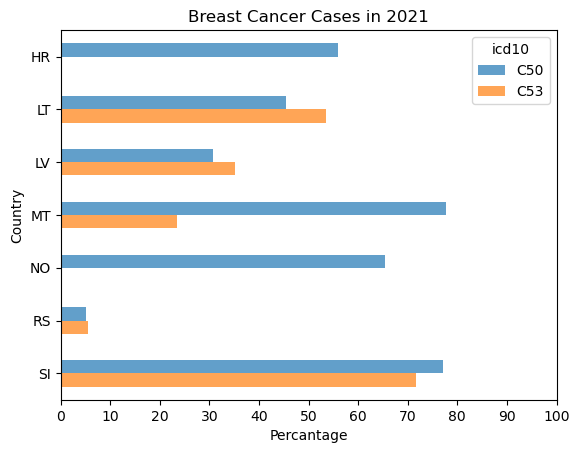

In [15]:
# Plotting 2021 data

tidy_2021.plot.barh(alpha = 0.7)

plt.title("Breast Cancer Cases in 2021")
plt.xlabel("Percantage")
plt.ylabel("Country")
plt.xticks(range(0, 110, 10))
plt.yticks(range(0, 7), tidy_2021.index)
plt.gca().invert_yaxis()
plt.show()

Just seven countries are presented in the 2021 data out of thirty-six. Slovenia shows very high number of Breast Cancer cases out of all observed - above 70%, while Serbia is on the bottom with under 10%. However we should mind the different practices in different countries the data has been collected. Also for the diagnosis have been labeled.

**Bulgaria Numbers**

We are interested only in Bulgaria breast cancer cases. What is the situation historically and if there is a trend that could reveals more. 

We assume bouth sources of information (source: PRG, SRV) are equally reliable, so we will aggregate our data by country, year and diagnosis.

In [16]:
bc_eurostat.source.unique()

array(['PRG', 'SRV'], dtype=object)

**Functions creation**

First function provides the data in the suitable size and type. Second function plots visuals to see the numbers.

In [17]:
def get_cntry_cases(dataset, geo_name, icd10_name):
    """
    The function scrunch the numbers by grouping a given dataset by country name, diagnosis and year.
    It filters for specific country and diagnosis. 
    """
        
    dataset = dataset[(dataset.geo == geo_name)
                     & (dataset.icd10 == icd10_name)]
    result = dataset.groupby(by = ["geo", "icd10", "time_period"])["obs_value"].mean().round(0)
    return result

In [18]:
def plot_cases_yearly(x1, y1, x2, y2, xticks, title):
    """ 
    This is a function for plotting Breast Cancer Cases per Year.
    We are using grouped bar chart.
    x1, y1 - correspond to data for icd10 = C50
    x2, y2 - correspond to data for icd10 = C53
    """
    
    width = 0.4
    plt.figure(figsize = (8, 6))

    plt.bar(x1 - 0.2, y1, width, alpha = 0.7, label = "C50")
    plt.bar(x2 + 0.2, y2, width, alpha = 0.7, label = "C53")

    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Percentage")
    plt.xticks(xticks)
    plt.yticks(range(0, 110, 10))
    plt.legend()
    plt.show()

In [19]:
# We are interested in data for Bulgaria. And separately data for both diagnosis.

bg_C50 = get_cntry_cases(bc_eurostat, "BG", "C50")
bg_C53 = get_cntry_cases(bc_eurostat, "BG", "C53")
bg_C50, bg_C53

(geo  icd10  time_period
 BG   C50    2008           22.0
             2014           32.0
             2015           14.0
             2016           21.0
             2017           21.0
             2019           36.0
 Name: obs_value, dtype: float64,
 geo  icd10  time_period
 BG   C53    2008           47.0
             2014           52.0
             2015            9.0
             2016           34.0
             2017           13.0
             2019           57.0
 Name: obs_value, dtype: float64)

In [20]:
bg_years_list_C50 = bg_C50.index.get_level_values(2)
bg_years_list_C53 = bg_C53.index.get_level_values(2)
bg_years_list_C50, bg_years_list_C50

(Int64Index([2008, 2014, 2015, 2016, 2017, 2019], dtype='int64', name='time_period'),
 Int64Index([2008, 2014, 2015, 2016, 2017, 2019], dtype='int64', name='time_period'))

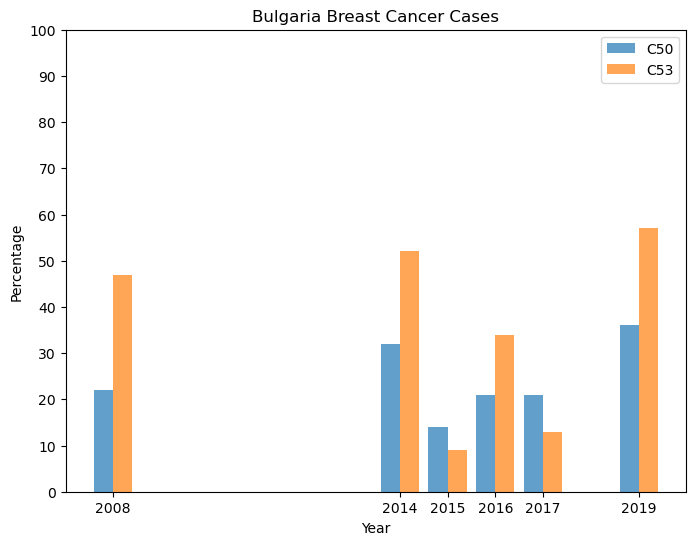

In [21]:
plot_cases_yearly(bg_years_list_C50, bg_C50, bg_years_list_C53, bg_C53, bg_years_list_C50, "Bulgaria Breast Cancer Cases")

It is hard to analyze what we see, so let's compare it with something "similar".
From EU countries Slovakia is with number of population close to the Bulgarian one. According to wikipedia - 5.4 millions in 2021. And 6.5 millions for Bulgaria. Let's check the figures in Slovakia to better understand the situation in Bulgaria.

**Slovakia Numbers**

In [22]:
# Slovakia data extraction

sk_C50 = get_cntry_cases(bc_eurostat, "SK", "C50")
sk_C53 = get_cntry_cases(bc_eurostat, "SK", "C53")
sk_C50, sk_C53

(geo  icd10  time_period
 SK   C50    2006           29.0
             2007           32.0
             2008           34.0
             2009           47.0
             2010           33.0
             2011           31.0
             2012           32.0
             2013           31.0
             2014           42.0
             2015           30.0
             2016           31.0
             2017           31.0
             2018           30.0
             2019           42.0
             2020           27.0
 Name: obs_value, dtype: float64,
 geo  icd10  time_period
 SK   C53    2009           56.0
             2010           49.0
             2011           48.0
             2012           47.0
             2013           47.0
             2014           58.0
             2015           48.0
             2016           46.0
             2017           46.0
             2018           46.0
             2019           59.0
             2020           40.0
 Name: obs_value, dtype: 

In [23]:
sk_years_list_C50 = sk_C50.index.get_level_values(2)
sk_years_list_C53 = sk_C53.index.get_level_values(2)
sk_years_list_C50, sk_years_list_C50

(Int64Index([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
             2017, 2018, 2019, 2020],
            dtype='int64', name='time_period'),
 Int64Index([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
             2017, 2018, 2019, 2020],
            dtype='int64', name='time_period'))

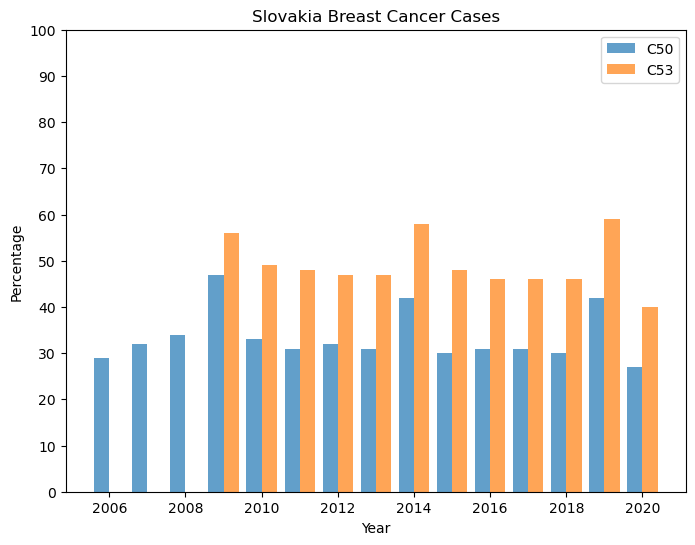

In [24]:
plot_cases_yearly(sk_years_list_C50, sk_C50, sk_years_list_C53, sk_C53, range(2006, 2021, 2), "Slovakia Breast Cancer Cases")

**Conclusion**

Bulgaria data is not fully presented. There is a gap in data between 2009 and 2013, as well 2018. It is hard to see any trend or pattern. Unlike Slovakia there are cases of C50 that exceeds C53 in two years - 2015 and 2017. The numbers in those two years are significantly lower than the rest, which may point to a gap in data collection or a bias. 

Unfortunately the original data is already agregated and is not compatible for further exploration on this matter.

### Winsconsin Dataset (Original)

This is a public data from [UCI machine learning repository](http://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original). It is a multivariate dataset with 699 instances and 9 attributes. Let's explore the data on the go.

**Attribute Information:**

Class Labels:
2 = benign, 4 = malignant

Additional Information

1. Sample code number:            id number
2. Clump Thickness:               1 - 10
3. Uniformity of Cell Size:       1 - 10
4. Uniformity of Cell Shape:      1 - 10
5. Marginal Adhesion:             1 - 10
6. Single Epithelial Cell Size:   1 - 10
7. Bare Nuclei:                   1 - 10
8. Bland Chromatin:               1 - 10
9. Normal Nucleoli:               1 - 10
10. Mitoses:                       1 - 10
11. Class:                        (2 for benign, 4 for malignant)

In [25]:
bc_original = pd.read_csv("data/tumor.csv")

In [26]:
bc_original.shape

(683, 11)

In [27]:
# Let's rename columns to be easier to work with

col_names_o = ["sample_id", "clump_tickness", "uniformity_cell_size", "uniformity_cell_shape", "marginal_adhesion", "single_epithelial_cell_size", "bare_nuclei", "bland_chromatin", "normal_nuclei", "mitoses", "class"]
bc_original.columns = col_names_o

In [28]:
# Attributes Info

bc_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   sample_id                    683 non-null    int64
 1   clump_tickness               683 non-null    int64
 2   uniformity_cell_size         683 non-null    int64
 3   uniformity_cell_shape        683 non-null    int64
 4   marginal_adhesion            683 non-null    int64
 5   single_epithelial_cell_size  683 non-null    int64
 6   bare_nuclei                  683 non-null    int64
 7   bland_chromatin              683 non-null    int64
 8   normal_nuclei                683 non-null    int64
 9   mitoses                      683 non-null    int64
 10  class                        683 non-null    int64
dtypes: int64(11)
memory usage: 58.8 KB


In [29]:
bc_original.bare_nuclei.unique()

array([ 1, 10,  2,  4,  3,  9,  7,  5,  8,  6], dtype=int64)

There is an information in the description that there are "?" values in the column "bare_nuclei". However after a check we see the table has no missing or strange values. It is well tidy and ready to work with. :)

First we are going to change values of "class" attribute. "Benign" indicates absence of cancer cells. "Malignant" means presence of cancer cells. This is the convention we are going to use to align this and following dataset.

- Benign: 0
- Malignant: 1

In [30]:
dic_diagnosis1 = {2: 0, 4: 1}
bc_original["class"] = bc_original["class"].map(dic_diagnosis1)
bc_original.head()

,sample_id,clump_tickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nuclei,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


**Functions Creation**

In [31]:
def diagnosis_freq(dataset_name, f_name):
    """
    It calculates frequency by class name.
    """
    
    all = dataset_name[f_name].count()
    malignants = dataset_name[f_name].sum()
    benigns = all - malignants
    
    print("Cases of benign are: ", benigns, ", which is ", '{:.0%}'.format(benigns / all))
    print("Cases of malignant are: ", malignants, ", which is ", '{:.0%}'.format(malignants / all))

In [32]:
def plot_freq(dataset_name, f_name):
    """
    It creates a pie chart in order to visualize the frequency by the class name chosen.
    """

    diagnosis_counts = dataset_name.groupby([f_name]).size().sort_values(ascending = False)

    plt.pie(diagnosis_counts 
            , labels = ["Benign", "Malignant"]
            , autopct='%1.0f%%'
            , colors = ["paleturquoise", "palegoldenrod"]
           )

    plt.title("Diagnosis Frequency")
    plt.gca().set_aspect("equal")
    plt.show()

In [33]:
def show_distributions(dataset_name, label_name, f_name, n_bins):
    """
    This function shows distribution of features/ columns per diagnosis.
    Parameter:
     - dataset_name - the dataframe, where to be looked
     - label_name - column name that holds the diagnosis values
     - f_name - the column to be shown
    """
    B = dataset_name[dataset_name[label_name] == 0][f_name]
    M = dataset_name[dataset_name[label_name] == 1][f_name]
    
    plt.figure(figsize = (8, 3))
    plt.hist(B, n_bins, alpha = 0.7, label = "Benign", color = "steelblue")
    plt.hist(M, n_bins, alpha = 0.7, label = "Malignant", color = "sandybrown")
    plt.semilogy()
    
    plt.title(f_name)
    plt.legend()
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.show() 

### Data Explorations

**What is the target frequency**

In [34]:
diagnosis_freq(bc_original, "class")

Cases of benign are:  444 , which is  65%
Cases of malignant are:  239 , which is  35%


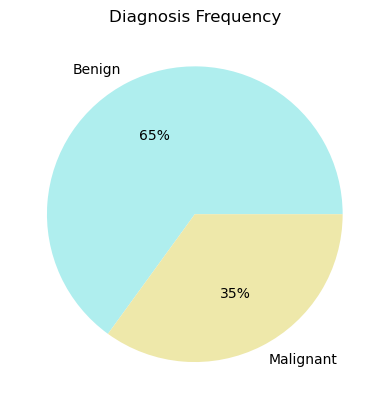

In [35]:
plot_freq(bc_original, "class")

The distribution observed is: 65% of the cases are labeled "benign" and 35% - "malignant". Benigns are around two times the number of malignants. This statistic is good for the patients, but gives us a thought if the target classes are well enough balanced.

**What is the distribution of the independent feature values**

Let's examine how different parameters describing tumor cells are distributed. And further more what this could tell us more about the data.

We need the features describing the tumor cells. "Class" represents the diagnosis and is our target variable. "Sample_id" is a code number, with very high entropy that is not related to tumor cells.

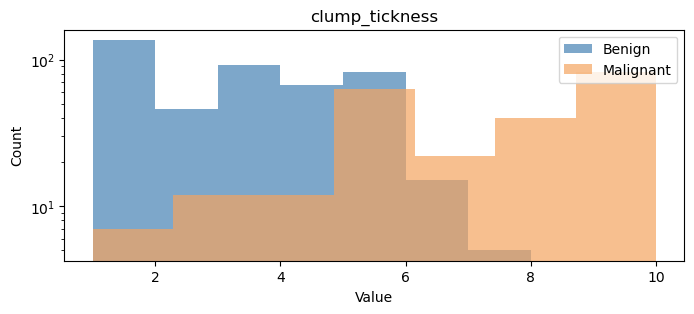

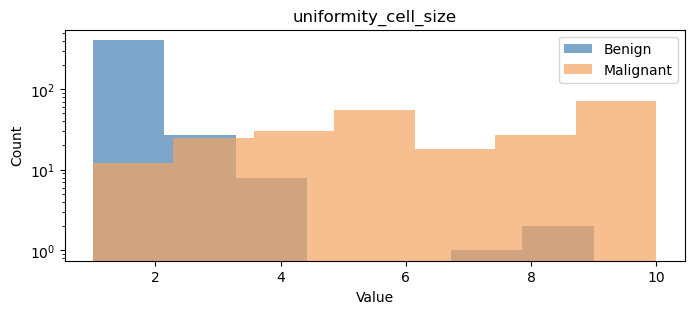

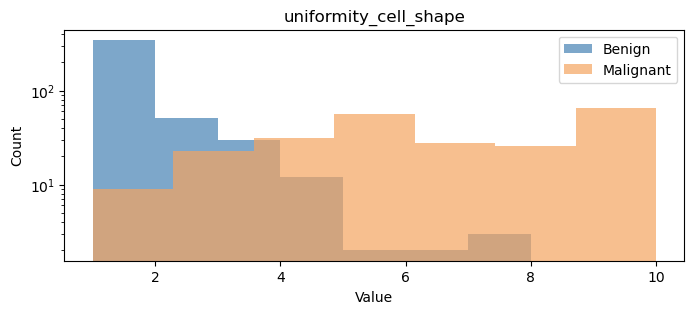

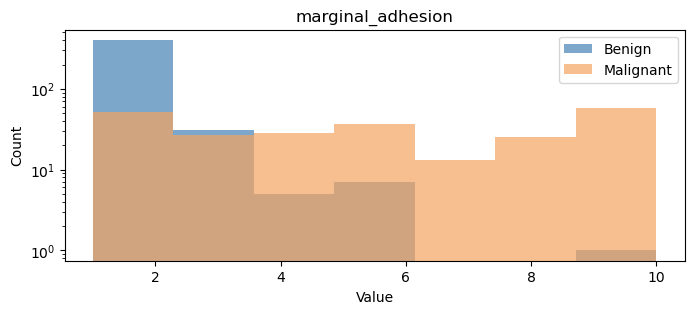

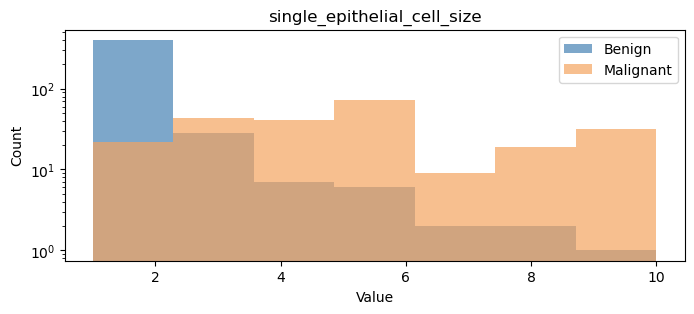

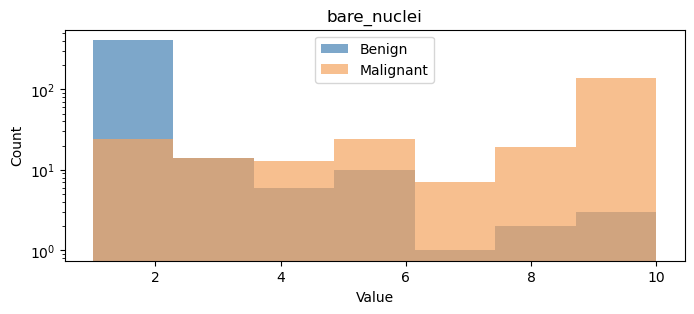

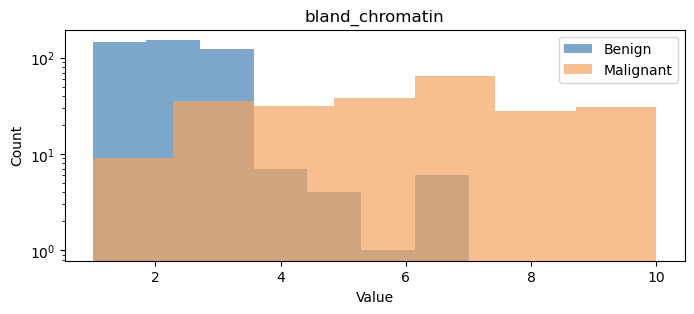

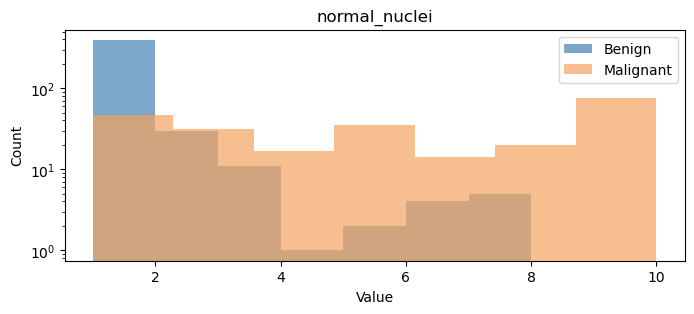

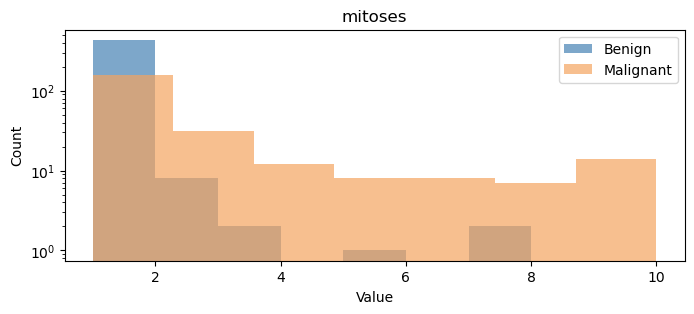

In [36]:
# Dropping columns "sample_id" and "class"  

o_features = bc_original.drop(columns = ["sample_id", "class"])

for column in o_features:
    show_distributions(bc_original, "class", column, 7)

In most of the distributions we see two orderliness for benigns. "Benign" parameters show high frequency around zero and getting lower counts when increasing the metric's value. "Malignant" distributions look alike. They have close to uniform destribution. 

Let's explore the third dataset to see what we are dealing with.

### Winsconsin Dataset (Diagnostic)

The dataset is public, available on the [UCI machine learning repository](http://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic). There are 569 observations and 32 columns. The features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

This data set was created by Dr. William H. Wolberg, physician at the University Of Wisconsin Hospital at Madison, Wisconsin, USA. To create the dataset Dr. Wolberg used fluid samples, taken from patients with solid breast masses and an easy-to-use graphical computer program called Xcyt, which is capable of perform the analysis of cytological features based on a digital scan. The program uses a curve-fitting algorithm, to compute ten features from each one of the cells in the sample, than it calculates the mean value, extreme value and standard error of each feature for the image, returning a 30 real-valuated vector.

**Attribute Information:**

1. ID number 
2. Diagnosis (M = malignant, B = benign) 
3. to 32. Ten real-valued features are computed for each cell nucleus:

- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension (“coastline approximation” - 1)

The mean, standard error and “worst” or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

In [37]:
bc_diagnostic = pd.read_csv("data\wdbc.data", header = None)

In [38]:
bc_diagnostic.shape

(569, 32)

In [39]:
# Renaming the columns to be more descriptive

col_names_diag = ["id", "diagnosis", "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean", "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se", "compactness_se", "concavity_se", "concave_points_se", "symmetry_se", "fractal_dimension_se", "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst", "compactness_worst", "concavity_worst", "concave_points_worst", "symmetry_worst", "fractal_dimension_worst"]
bc_diagnostic.columns = col_names_diag

In [40]:
bc_diagnostic.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


**Types and Null Values**

In [41]:
# Let's check types and null values

bc_diagnostic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

There are no missing values. All columns are numeric, which is great - the table looks terrific! We can go ahead and do some analysis, transformations and apllying algorythms.

**What is the target frequency**

The feature we are going to predict is diagnosis. We have two unique values - "B" and "M". Let's transform object type "diagnosis" to numerical type: 0 - benign; 1 - malignant, as this is our convention for the target variable.

In [42]:
bc_diagnostic.diagnosis.unique()

array(['M', 'B'], dtype=object)

In [43]:
dic_diagnosis2 = {"B": 0, "M": 1}
bc_diagnostic["diagnosis"] = bc_diagnostic["diagnosis"].map(dic_diagnosis2)
bc_diagnostic.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


**What is the frequency by diagnosis**

In [44]:
diagnosis_freq(bc_diagnostic, "diagnosis")

Cases of benign are:  357 , which is  63%
Cases of malignant are:  212 , which is  37%


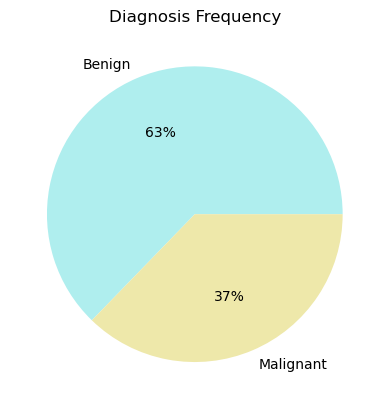

In [45]:
plot_freq(bc_diagnostic, "diagnosis")

The distribution per diagnosis label is similar to the previous dataset. There is a slight imbalance of the target classes in favor to "benign".

**What columns' stats could tell**

In [46]:
bc_diagnostic.describe().T

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037183e+07,1.250206e+08,8670.000000,869218.000000,906024.000000,8.813129e+06,9.113205e+08
diagnosis,569.0,3.725835e-01,4.839180e-01,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00
radius_mean,569.0,1.412729e+01,3.524049e+00,6.981000,11.700000,13.370000,1.578000e+01,2.811000e+01
texture_mean,569.0,1.928965e+01,4.301036e+00,9.710000,16.170000,18.840000,2.180000e+01,3.928000e+01
perimeter_mean,569.0,9.196903e+01,2.429898e+01,43.790000,75.170000,86.240000,1.041000e+02,1.885000e+02
area_mean,569.0,6.548891e+02,3.519141e+02,143.500000,420.300000,551.100000,7.827000e+02,2.501000e+03
smoothness_mean,569.0,9.636028e-02,1.406413e-02,0.052630,0.086370,0.095870,1.053000e-01,1.634000e-01
compactness_mean,569.0,1.043410e-01,5.281276e-02,0.019380,0.064920,0.092630,1.304000e-01,3.454000e-01
concavity_mean,569.0,8.879932e-02,7.971981e-02,0.000000,0.029560,0.061540,1.307000e-01,4.268000e-01
concave_points_mean,569.0,4.891915e-02,3.880284e-02,0.000000,0.020310,0.033500,7.400000e-02,2.012000e-01


**What is the distribution of the independent feature values**

We need the features describing the tumor cells, thus we are going to work with columns of interest. We are droping *id* as it is has high entropy with only unique values. We are droping column *diagnosis*, as this is the feature we are going to predict.

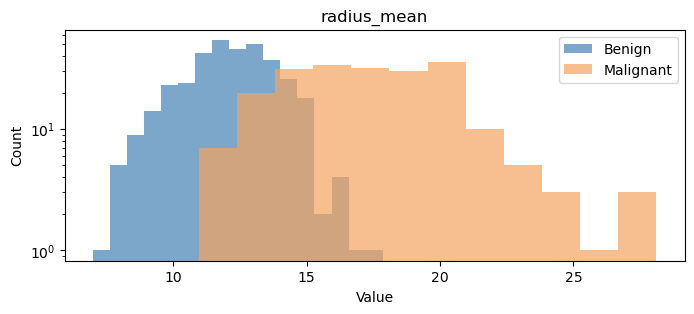

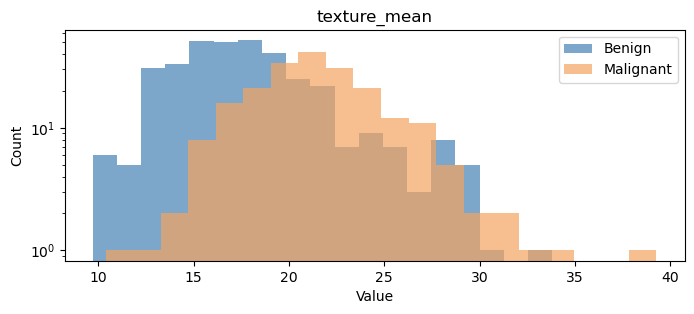

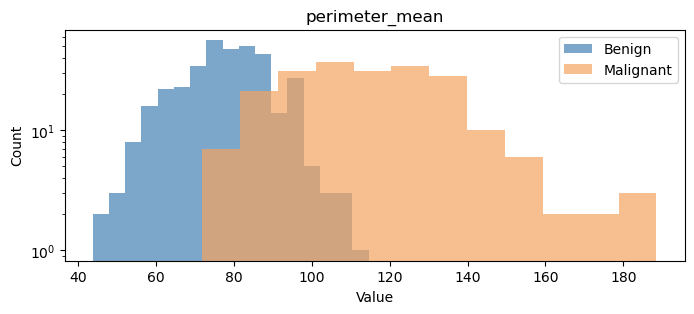

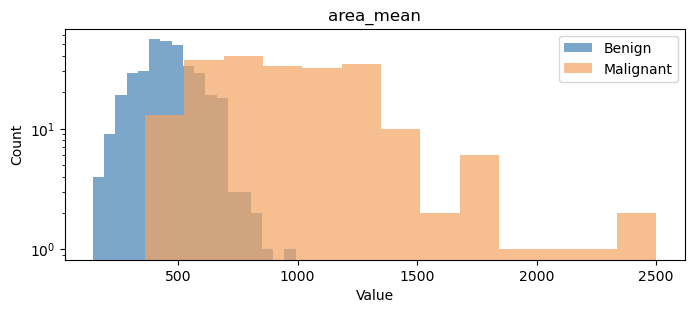

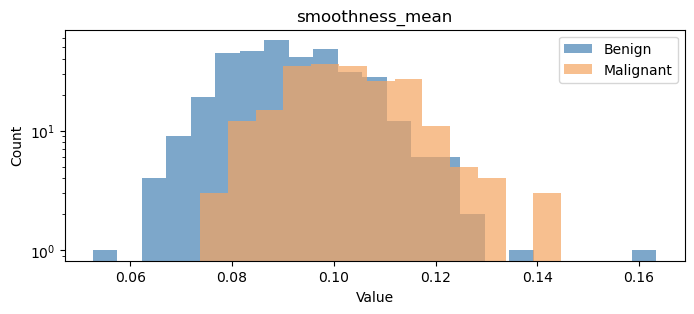

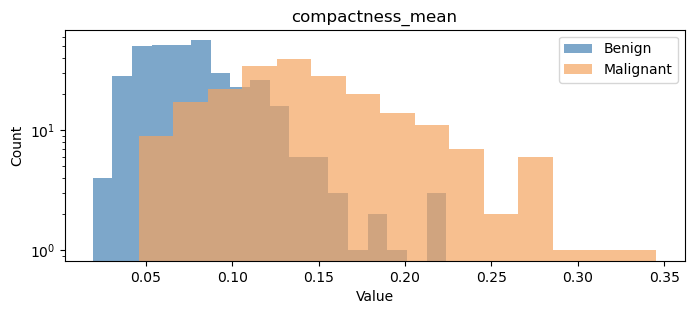

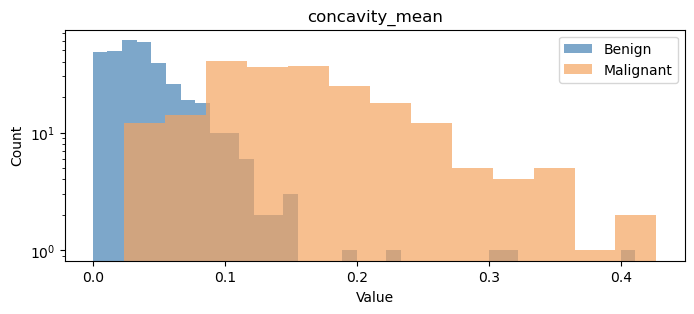

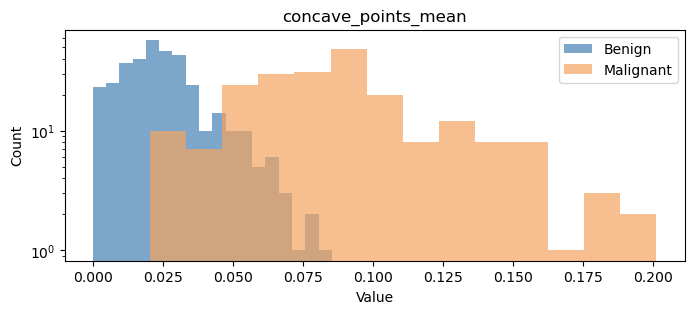

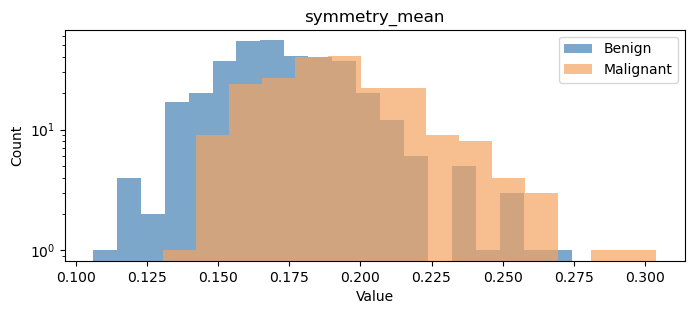

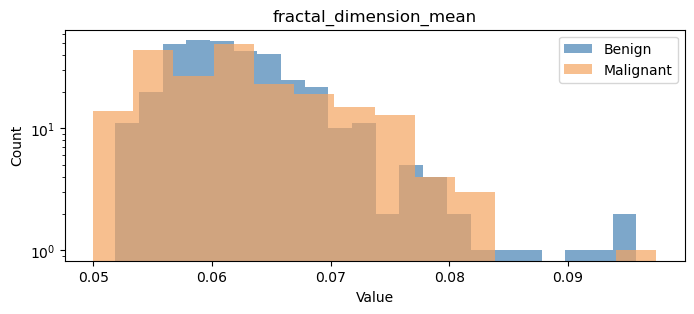

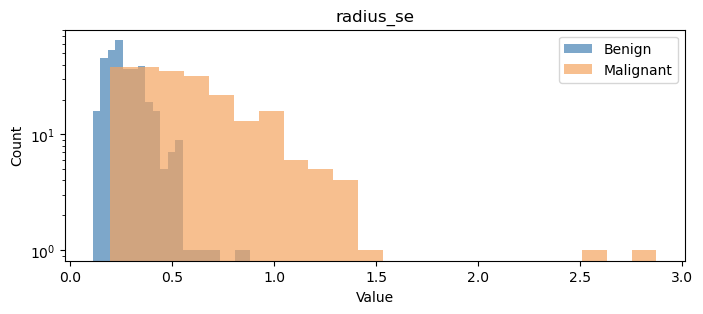

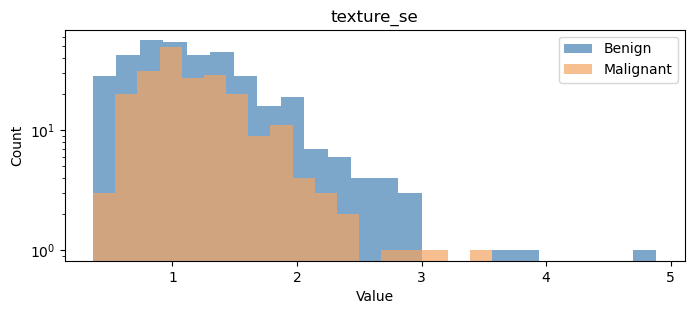

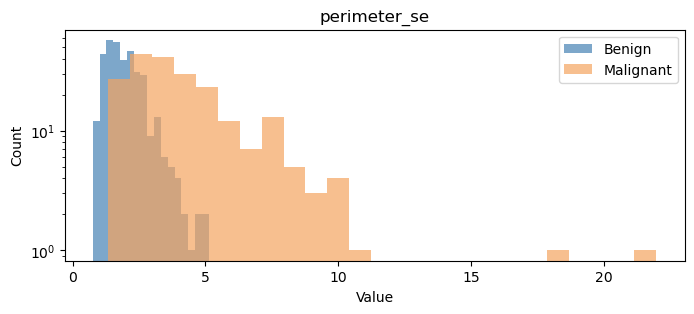

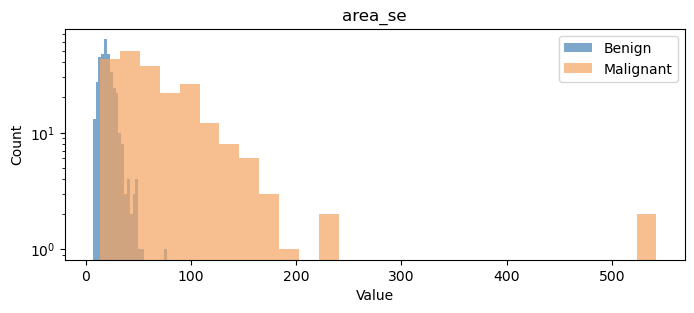

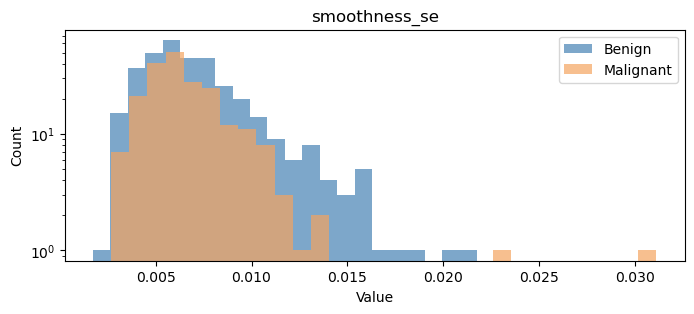

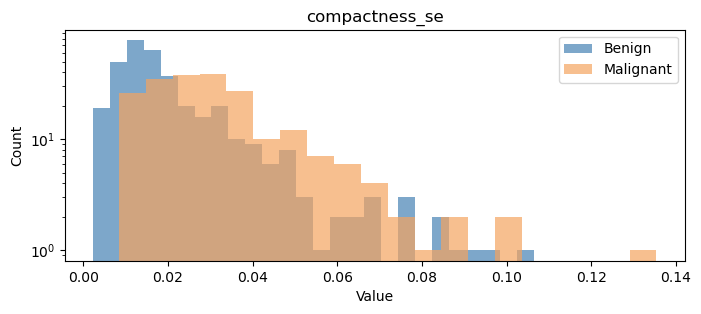

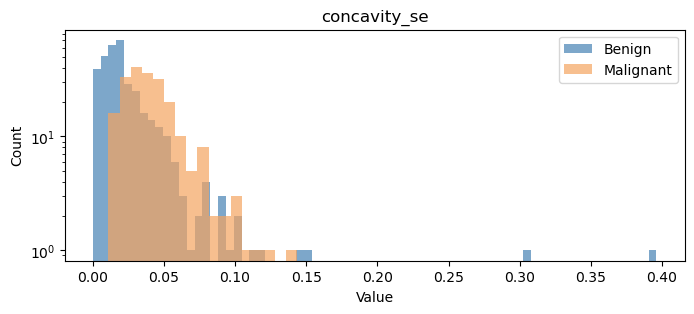

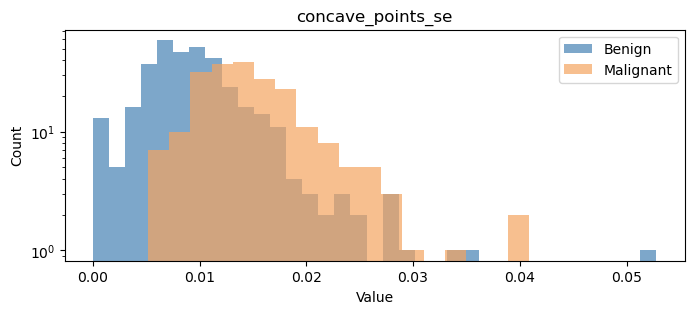

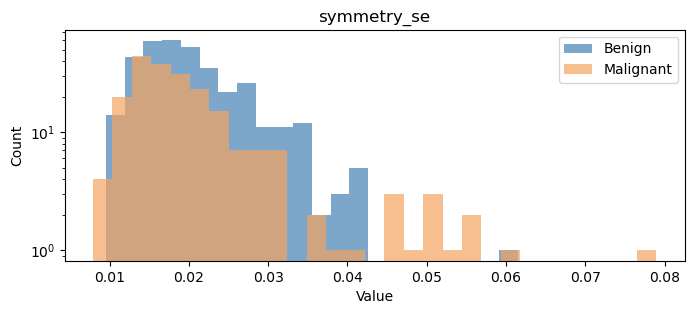

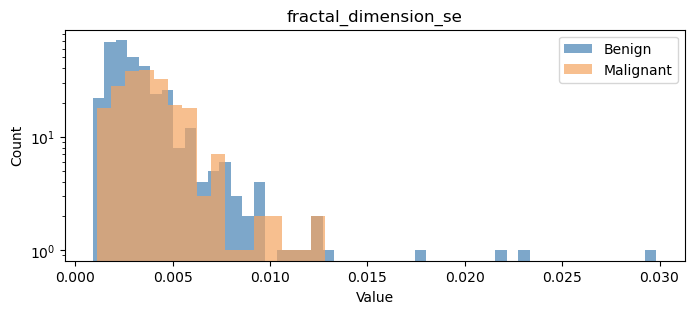

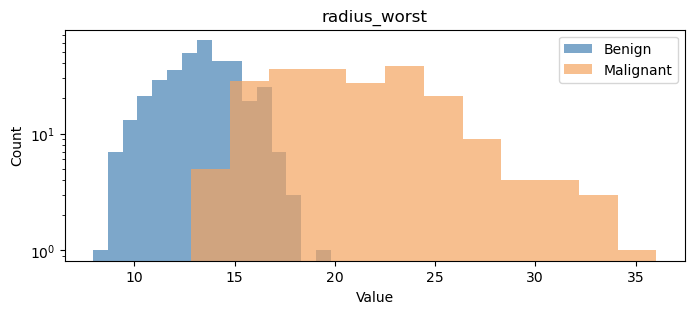

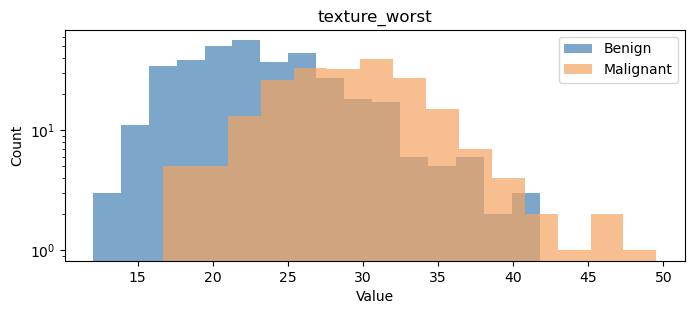

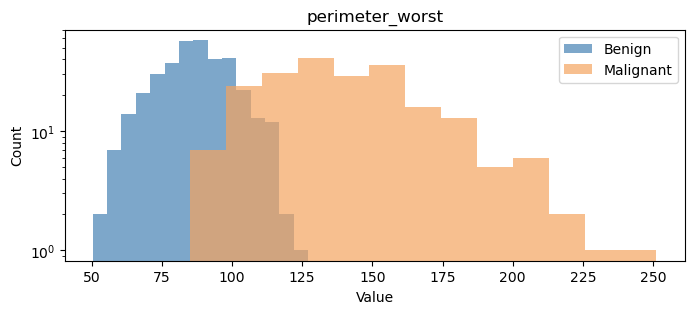

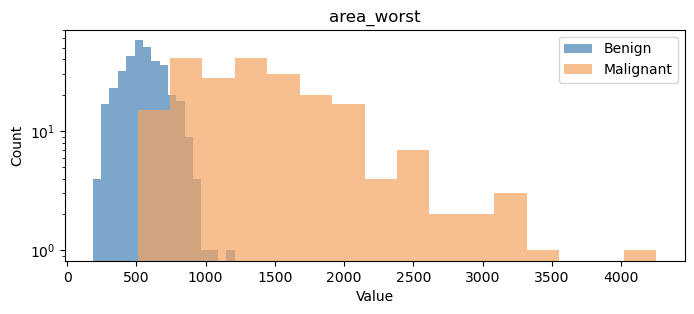

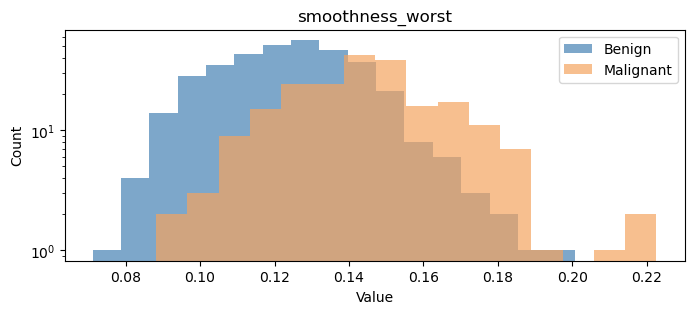

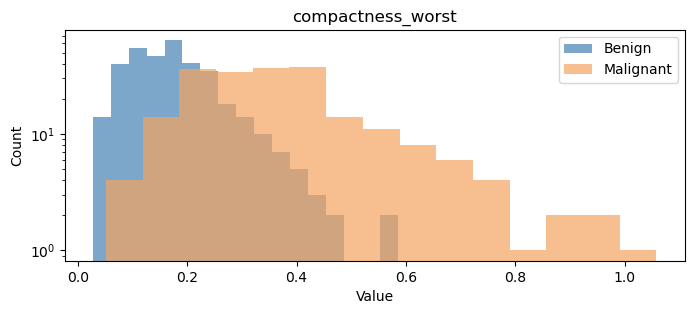

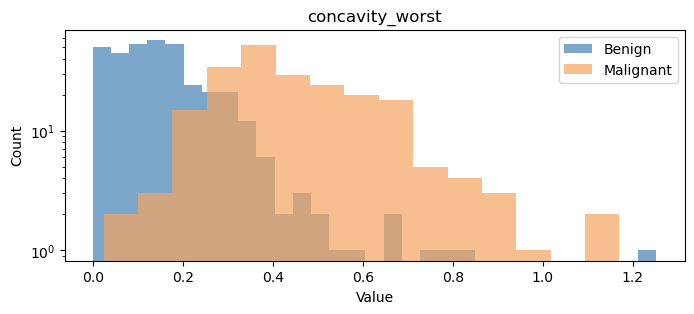

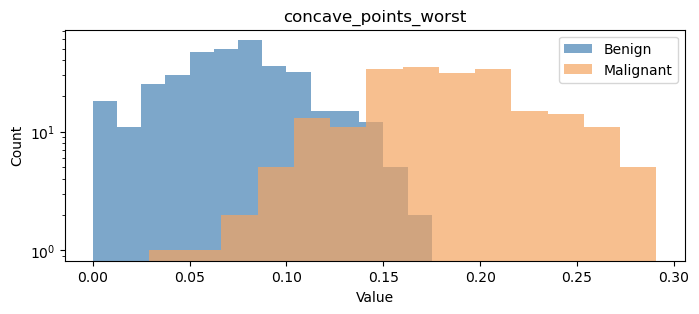

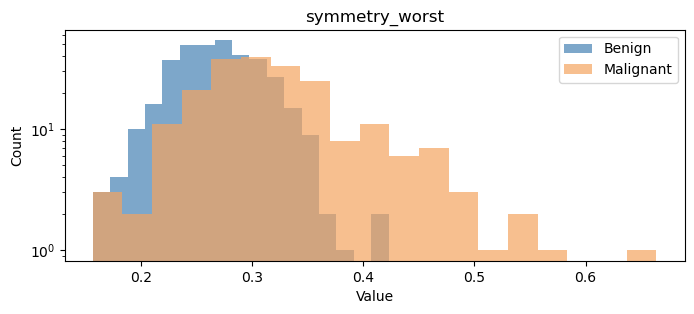

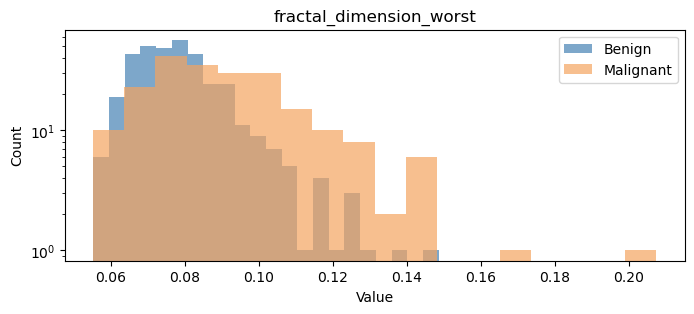

In [47]:
# Dropping columns "id" and "diagnosis" 

d_features = bc_diagnostic.drop(columns = ["id", "diagnosis"])

for column in d_features:
    show_distributions(bc_diagnostic, "diagnosis", column, "fd")

Most of the distributions are Gaussian. There is no perfect separation by diagnosis to any of the features. Partial separation could be seen for: *perimeter_mean, area_mean, concave_points_mean, radius_worst, perimeter_worst, concavity_worst, concave_points_worst*. We do have as well tight superposition for some of the values, like *smoothness_mean, symmetry_mean, fractal_dimension_mean, texture_se, smoothness_se, symmetry_se, fractal_dimension_se*.

### Data Join

Until now we explored 3 tables with breast cancer data. First dataset is agregated, showing annual percentage per country without acknowledging us what are the absolute numbers. The data is agregated only for malignant cases. This table is not suitable to be joined or further used for a prediction model.   

The other two tables resamble to each other more. Their granularity is similar, having "id" in common. They contain observations with cathegorical variable "diagnosis" with two values - benign, malignant. The rest of their attributes describe tumor cells. 

Both datasets are relatively small and we can try to join the data. This way we will increase observations and enrich the features. Our goal is to improve our approach to **find relations describing diagnosis**. The column both tables have is "id". Let's try to join them by it.

In [48]:
# Join second and third dataset

bc_original.merge(bc_diagnostic
                  , left_on = "sample_id"
                  , right_on = "id"
                 )

,sample_id,clump_tickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nuclei,mitoses,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst


Unfortunately *ids* are not the same. And we end with 0 observations. We need to find another way to merge our data.

### Data Preparation

**How many of the features are strongly correlated**

We are going to explore if features have strong lenear dependancy, e. g. Pearson coefficient above 0.92. The variables with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable. So, when two features have high correlation, we can drop one of the two features.

In [49]:
# Calculating Pearson correlation between columns (Breast Cancer Original)

corr_table1 = o_features.corr().unstack().sort_values(ascending = False).drop_duplicates()
corr_table1

clump_tickness               clump_tickness                 1.000000
uniformity_cell_size         uniformity_cell_shape          0.907228
                             bland_chromatin                0.755559
single_epithelial_cell_size  uniformity_cell_size           0.753544
bland_chromatin              uniformity_cell_shape          0.735344
uniformity_cell_shape        single_epithelial_cell_size    0.722462
uniformity_cell_size         normal_nuclei                  0.719346
normal_nuclei                uniformity_cell_shape          0.717963
bare_nuclei                  uniformity_cell_shape          0.713878
marginal_adhesion            uniformity_cell_size           0.706977
bare_nuclei                  uniformity_cell_size           0.691709
marginal_adhesion            uniformity_cell_shape          0.685948
bland_chromatin              bare_nuclei                    0.680615
marginal_adhesion            bare_nuclei                    0.670648
                             bland

In this dataset there are no features with higher than 0.92 correlation. Let's check Breast Cancer Diagnostic dataset.

In [50]:
# Calculating Pearson correlation between columns (Dataset Breast Cancer Diagnostic)

corr_table2 = d_features.corr().unstack().sort_values(ascending = False).drop_duplicates()
corr_table2 

radius_mean             radius_mean               1.000000
perimeter_mean          radius_mean               0.997855
perimeter_worst         radius_worst              0.993708
radius_mean             area_mean                 0.987357
area_mean               perimeter_mean            0.986507
                                                    ...   
fractal_dimension_mean  area_worst               -0.231854
                        radius_worst             -0.253691
                        perimeter_mean           -0.261477
                        area_mean                -0.283110
radius_mean             fractal_dimension_mean   -0.311631
Length: 436, dtype: float64

In [51]:
# Extract columns with higher than 0.92 correlation

CORR_COEF = 0.92

highly_corr_features = corr_table2[corr_table2 > CORR_COEF]
highly_corr_features

radius_mean          radius_mean        1.000000
perimeter_mean       radius_mean        0.997855
perimeter_worst      radius_worst       0.993708
radius_mean          area_mean          0.987357
area_mean            perimeter_mean     0.986507
area_worst           radius_worst       0.984015
perimeter_worst      area_worst         0.977578
radius_se            perimeter_se       0.972794
perimeter_worst      perimeter_mean     0.970387
radius_worst         radius_mean        0.969539
perimeter_mean       radius_worst       0.969476
perimeter_worst      radius_mean        0.965137
radius_worst         area_mean          0.962746
area_mean            area_worst         0.959213
                     perimeter_worst    0.959120
area_se              radius_se          0.951830
area_worst           perimeter_mean     0.941550
                     radius_mean        0.941082
perimeter_se         area_se            0.937655
concave_points_mean  concavity_mean     0.921391
dtype: float64

In [52]:
# Getting first element out of a pair, excluding pairs of the same element

high_corr_vars = []

for a in highly_corr_features.index.get_level_values(0):
    for b in highly_corr_features.index.get_level_values(1):
        if a != b:
            high_corr_vars.append(a)

high_corr_vars = set(high_corr_vars)

In [53]:
print("Highly correlated columns are", len(high_corr_vars))

Highly correlated columns are 10


In [54]:
# Feature selection - 22 columns were left out of 30

lin_indep_features = bc_diagnostic.drop(high_corr_vars, axis = 1)
lin_indep_features.shape

(569, 22)

### Principal Component Analysis

PCA doesn’t just center and rescale the individual variables. It constructs a set of orthogonal (non-collinear, uncorrelated, independent) variables. For many model fitting algorithms, these variables are much easier to fit than “natural” (somewhat collinear, somewhat correlated, not-independent) variables.

Let's first find new variables after PCA with our original dataset. And after that repeat the process with reduced dataset (after feature selection due to high correlation).

In [55]:
# PCA with non-reduced features (30)

pca = PCA()
pca.fit(d_features)

t_matrix = pca.components_
t_matrix.shape

(30, 30)

We received a matrix 30 x 30. This is our T matrix. What we did is to change our basis. We multipy with lambda all variables to receive the new basis.

In [56]:
t_matrix[:, 1]

array([ 2.19657026e-03, -2.88160658e-03, -6.35497857e-03, -3.62415111e-01,
       -4.43187450e-01, -2.13486089e-01, -7.84253475e-01, -6.87405638e-02,
        4.08376429e-03,  7.66679112e-02,  2.90168453e-02, -1.77040388e-03,
        4.23058843e-03,  1.98471260e-03,  7.07543943e-03, -3.71772553e-03,
       -1.74411881e-03, -1.41458884e-04, -1.24960485e-03,  2.12853660e-04,
       -5.08486619e-04,  3.25522689e-04,  5.70803677e-04,  7.33059897e-05,
        4.32289948e-04, -6.85637302e-04, -2.03286434e-04, -1.08812487e-04,
       -1.28702530e-04,  4.67664637e-06])

In [57]:
changed_basis = pca.explained_variance_ratio_
changed_basis

array([9.82044672e-01, 1.61764899e-02, 1.55751075e-03, 1.20931964e-04,
       8.82724536e-05, 6.64883951e-06, 4.01713682e-06, 8.22017197e-07,
       3.44135279e-07, 1.86018721e-07, 6.99473205e-08, 1.65908880e-08,
       6.99641650e-09, 4.78318306e-09, 2.93549214e-09, 1.41684927e-09,
       8.29577731e-10, 5.20405883e-10, 4.08463983e-10, 3.63313378e-10,
       1.72849737e-10, 1.27487508e-10, 7.72682973e-11, 6.28357718e-11,
       3.57302295e-11, 2.76396041e-11, 8.14452259e-12, 6.30211541e-12,
       4.43666945e-12, 1.55344680e-12])

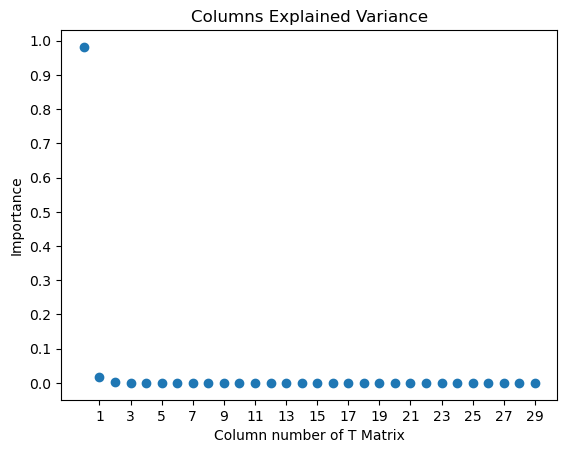

In [58]:
# Visualize explained variance by the new variables 

plt.scatter(range(len(changed_basis)), changed_basis)

plt.xticks(np.arange(1, 31, 2))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Column number of T Matrix")
plt.ylabel("Importance")
plt.title("Columns Explained Variance")
plt.show()

Wow! It looks that first column in transformed space explains 98% of all information in our dataset. Let's reduce dimenstionality by cutting the features to 1.

**PCA of selected independent features**

In [59]:
pca = PCA()
pca.fit(lin_indep_features)

t_matrix = pca.components_
t_matrix.shape

(22, 22)

We received a matrix 22 x 22. This is our second T matrix.

In [60]:
t_matrix[:, 1]

array([ 1.53932217e-10,  2.97910539e-02,  2.43849041e-02, -5.30313271e-01,
        7.46643275e-01, -3.92055225e-01, -2.64188348e-02, -2.30862552e-02,
        5.86198263e-02,  3.59469374e-02,  6.81043538e-03,  5.93411175e-03,
       -3.39486894e-03, -6.22212091e-03, -5.65065406e-04,  2.58000141e-03,
        7.93351101e-04, -3.02883661e-05, -5.99015042e-04, -1.68991751e-03,
       -3.54572425e-04, -2.15884009e-04])

In [61]:
changed_basis = pca.explained_variance_ratio_
changed_basis

array([1.00000000e+00, 3.44767137e-15, 1.38063055e-16, 1.90869905e-17,
       1.09391909e-17, 2.27656476e-18, 2.67451903e-19, 1.39540708e-19,
       8.74826791e-20, 3.18461337e-20, 2.74640156e-20, 1.72041302e-20,
       1.26346714e-20, 7.11029747e-21, 4.47519208e-21, 2.24482539e-21,
       1.64033619e-21, 9.27374579e-22, 2.81549792e-22, 2.71354589e-22,
       1.38690619e-22, 5.08304723e-23])

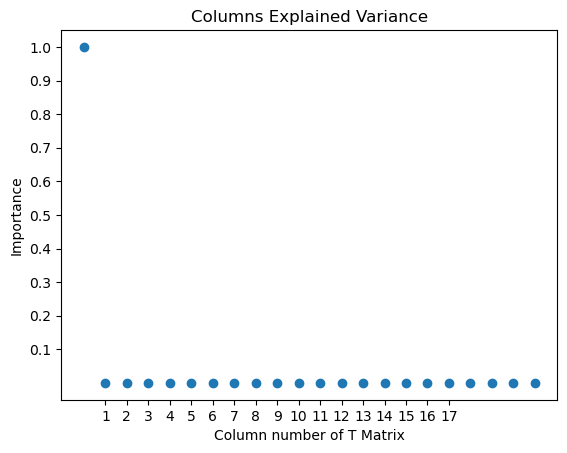

In [62]:
# Visualize explained variance by the new variables 

plt.scatter(range(len(changed_basis)), changed_basis)

plt.xticks(np.arange(1, 18, 1))
plt.yticks(np.arange(0.1, 1.1, 0.1))
plt.xlabel("Column number of T Matrix")
plt.ylabel("Importance")
plt.title("Columns Explained Variance")
plt.show()

Wow! It looks that first feature explains 100% of all information in our dataset. Let's reduce dimenstionality by cutting the features to one again.

Although both transformations did amazing job, second reduced dataset (including only independant features) make it a little better. It explains 100% of the data variance. We are going to keep this selection in our further steps. Next we are applying a prediction algorithm.

In [63]:
pca = PCA(1)

pca.fit(o_features)
transformed_data1 = pca.transform(o_features)
transformed_data1.shape

(683, 1)

In [64]:
pca.fit(lin_indep_features)
transformed_data2 = pca.transform(lin_indep_features)
transformed_data2.shape

(569, 1)

### Join the two datasets after a dimensionality reduction with PCA

In [65]:
# Join variables of two tables together

transformed_data = np.vstack((transformed_data1, transformed_data2))
transformed_data.shape

(1252, 1)

In [66]:
# Join target variable of two datasets together

y1_array = np.array(bc_original["class"])
y2_array = np.array(bc_diagnostic.diagnosis)

y = np.hstack((y1_array, y2_array))
y.shape

(1252,)

### Columns Separation (X, y)

In [67]:
# Separate the feature columns from the target column

X = transformed_data
X, y

(array([[-4.48210185e+00],
        [ 4.81965073e+00],
        [-4.63295991e+00],
        ...,
        [-2.94448774e+07],
        [-2.94445904e+07],
        [-3.02790804e+07]]),
 array([0, 0, 0, ..., 1, 1, 0], dtype=int64))

**Training and Test Set**

In [68]:
# Split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 11)

In [69]:
# Check the shape of X_train and X_test

X_train.shape, X_test.shape

((876, 1), (376, 1))

### Prediction Algorithm

**Logistic Regression**

In [70]:
# Fitting Logistic Regression To the training set

classifier = LogisticRegression(random_state = 11)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=11)

In [71]:
# Predicting the test set result using predict function under Logistic Regression

y_pred = classifier.predict(X_test)

In [72]:
# Making the confusion matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[223,  19],
       [ 49,  85]], dtype=int64)

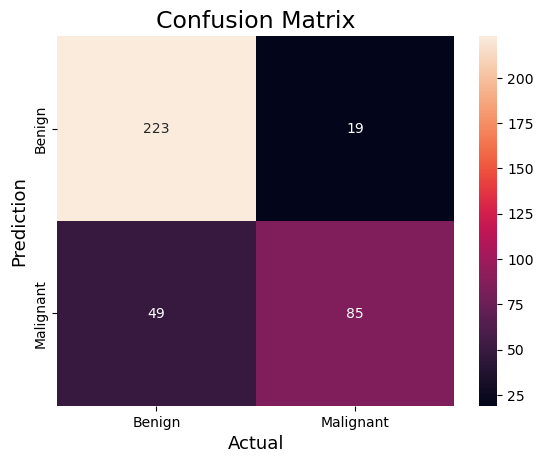

In [73]:
sns.heatmap(cm
            , annot = True
            , fmt = "g"
            , xticklabels = ["Benign", "Malignant"]
            , yticklabels = ["Benign", "Malignant"]
           )
plt.ylabel("Prediction", fontsize = 13)
plt.xlabel("Actual", fontsize = 13)
plt.title("Confusion Matrix", fontsize = 17)
plt.show()

In [74]:
# Check accuracy score with accuracy score

print("Model accuracy score: {0:0.3f}".format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.819


This model evaluation metric gives us some information. In this case it shows what is the percentage of correctly predicted cases - 82%. However we seem to be more interested in how good our model is to predict correctly malignant cases. We can do with recall metric.
Further more we need to assure reducng number of incorectly predicted malignants as benigns, as those cases we underestimate and those people could die. Then precision metric is most important for us.

In [75]:
# Recall score

print("Model recall score: {0:0.3f}".format(recall_score(y_test, y_pred)))

Model recall score: 0.634


In [76]:
# Precision

print("Model precision score: {0:0.3f}".format(precision_score(y_test, y_pred)))

Model precision score: 0.817


We achieved accuracy of 82% for the corectly predicted malignants with the **Logistic Regression** algorithm. We used data from **two datasets** and we **reduced dimentions with PCA** for both of them.

### References

1. O. L. Mangasarian and W. H. Wolberg: "Cancer diagnosis via linear programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18.

2. William H. Wolberg and O.L. Mangasarian: "Multisurface method of pattern separation for medical diagnosis applied to breast cytology", Proceedings of the National Academy of Sciences, U.S.A., Volume 87, December 1990, pp 9193-9196.

3. O. L. Mangasarian, R. Setiono, and W.H. Wolberg: "Pattern recognition via linear programming: Theory and application to medical diagnosis", in: "Large-scale numerical optimization", Thomas F. Coleman and Yuying Li, editors, SIAM Publications, Philadelphia 1990, pp 22-30.

4. K. P. Bennett & O. L. Mangasarian: "Robust linear programming discrimination of two linearly inseparable sets", Optimization Methods and Software 1, 1992, 23-34 (Gordon & Breach Science Publishers).

[Eurostat](https://ec.europa.eu/eurostat)

[UCI](http://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)

[RStudio "Wisconsin Breast Cancer (Diagnostic) DataSet Analysis"](https://rstudio-pubs-static.s3.amazonaws.com/344010_1f4d6691092d4544bfbddb092e7223d2.html)

[Kaggle "PCA and LDA Implementation"](https://www.kaggle.com/code/bhatnagardaksh/pca-and-lda-implementation)